In [15]:
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
import torch.utils.data as Data
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

import numpy as np
import math

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [17]:
from torchvision import datasets
from torchvision.transforms import ToTensor

In [18]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download = True,
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download = False,
)

## HW1 : 3.1 Can network fit random labels?

In [19]:
print("Before Shuffling labels:")
print(train_data.targets[0:10])
print(test_data.targets[0:10])

## Shuffle the labels
torch.manual_seed(42)

idx = torch.randperm(train_data.targets.shape[0])
train_data.targets = train_data.targets[idx].view(train_data.targets.size())

idx = torch.randperm(test_data.targets.shape[0])
test_data.targets = test_data.targets[idx].view(test_data.targets.size())

print("After Shuffling labels:")
print(train_data.targets[0:10])
print(test_data.targets[0:10])

Before Shuffling labels:
tensor([5, 0, 4, 1, 9, 2, 1, 3, 1, 4])
tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])
After Shuffling labels:
tensor([6, 7, 6, 9, 4, 2, 1, 3, 8, 9])
tensor([8, 1, 4, 2, 9, 2, 6, 9, 0, 5])


In [20]:
print(train_data)
print(train_data.data.size())
print(train_data.targets.size())

print(test_data)
print(test_data.data.size())
print(test_data.targets.size())

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
torch.Size([60000, 28, 28])
torch.Size([60000])
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()
torch.Size([10000, 28, 28])
torch.Size([10000])


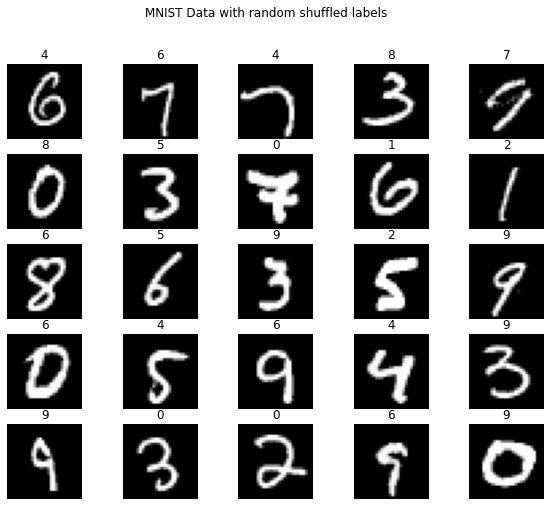

In [21]:
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
plt.suptitle("MNIST Data with random shuffled labels")
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [22]:
loaders = {'train': Data.DataLoader(train_data,
                                               batch_size=100,
                                               shuffle=True,
                                               num_workers=1),
          'test': Data.DataLoader(test_data,
                                             batch_size=100,
                                             shuffle=True,
                                             num_workers=1)
          }

loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1520e4e8fbe0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1520e4e8fa00>}

In [23]:
class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1), X

cnn_models = [DNN1().to(device)]
loss_functions = []
optimizers = []
num_epochs = 12

for model in cnn_models:
    print(model)
    model.train()
    optimizers.append(optim.Adam(model.parameters(), lr = 0.01))
    loss_functions.append(nn.CrossEntropyLoss())
    
model_loss=[]
model_accuracy=[]
model_weights = []
model_grad_norms = []

model_test_loss = []
model_test_accuracy = []

for model, optimizer, loss_func in zip(cnn_models,optimizers,loss_functions):

    # Train the model
    total_step = len(loaders['train'])

    train_loss =[]
    train_acc = []
    test_loss = []
    test_acc =[]
    train_grad_norm = []
    for epoch in range(num_epochs):
        correct=0
        b_loss=[]
        b_acc=[]
        b_grad_norm = []
        for i, (images, labels) in enumerate(loaders['train']):
            model.train()
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device) # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)

            # clear gradients for this training step   
            optimizer.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step() 

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted==b_y).sum()

            b_loss.append(loss.detach().cpu().item())
            b_acc.append(float(correct)*100/float(100*(i+1)))

            grad_all = 0.0
            for p in model.parameters():
                grad=0.0
                if p.grad is not None:
                    grad = (p.grad.cpu().data.numpy() ** 2).sum()
                grad_all +=grad
            grad_norm = grad_all**0.5

            b_grad_norm.append(grad_norm)

            if (i+1)%200==0 and epoch%3==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, i + 1, total_step, b_loss[-1],b_acc[-1]))


        train_grad_norm.extend(b_grad_norm)
        train_loss.append(np.average(b_loss))
        train_acc.append(np.average(b_acc))

        model.eval()
        correct=0
        with torch.no_grad():
            b_tloss=[]
            b_tacc=[]
#             b_tgrad_norm = []
            for ti, (images, labels) in enumerate(loaders['test']):
                b_tx = Variable(images).to(device) # batch x
                b_ty = Variable(labels).to(device)   # batch y
                output = model(b_tx)[0]               
                loss = loss_func(output, b_ty)
                
                predicted = torch.max(output.data, 1)[1]
                correct += (predicted==b_ty).sum()

                b_tloss.append(loss.detach().cpu().item())
                b_tacc.append(float(correct)*100/float(100*(ti+1)))
                
                if(ti+1)%200==0 and epoch%3==0:
                    print ('Epoch [{}/{}], Step [{}/{}], Test Loss: {:.4f}, Test Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, ti + 1, total_step, b_tloss[-1],b_tacc[-1]))

            test_loss.append(np.average(b_tloss))
            test_acc.append(np.average(b_tacc))
        
        
        if epoch%3==0:
#                 w_conv1 = torch.flatten(model.conv1.weight)
#                 w_conv2 = torch.flatten(model.conv2.weight)
#                 w_conv3 = torch.flatten(model.conv3.weight)
#                 w_fc1 = torch.flatten(model.fc1.weight)
#                 w_fc2 = torch.flatten(model.fc2.weight)
#                 weights = torch.cat((w_conv1,w_conv2,w_conv3,w_fc1,w_fc2),0)
            w_linear1 = torch.flatten(model.linear1.weight)
            w_linear2 = torch.flatten(model.linear2.weight)
            w_linear3 = torch.flatten(model.linear3.weight)
            weights = torch.cat((w_linear1,w_linear2,w_linear3),0)
            model_weights.append(weights)

    model_grad_norms.append(train_grad_norm)
    model_loss.append(train_loss)
    model_accuracy.append(train_acc)
    model_test_loss.append(test_loss)
    model_test_accuracy.append(test_acc)

DNN1(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)
Epoch [1/12], Step [200/600], Loss: 2.3139, Accuracy: 11.140%
Epoch [1/12], Step [400/600], Loss: 2.3103, Accuracy: 10.988%
Epoch [1/12], Step [600/600], Loss: 2.2939, Accuracy: 10.983%
Epoch [4/12], Step [200/600], Loss: 2.3081, Accuracy: 11.065%
Epoch [4/12], Step [400/600], Loss: 2.2989, Accuracy: 11.280%
Epoch [4/12], Step [600/600], Loss: 2.3004, Accuracy: 11.057%
Epoch [7/12], Step [200/600], Loss: 2.3086, Accuracy: 11.250%
Epoch [7/12], Step [400/600], Loss: 2.2931, Accuracy: 11.115%
Epoch [7/12], Step [600/600], Loss: 2.3041, Accuracy: 11.113%
Epoch [10/12], Step [200/600], Loss: 2.2846, Accuracy: 11.200%
Epoch [10/12], Step [400/600], Loss: 2.3072, Accuracy: 11.248%
Epoch [10/12], Step [600/600], Loss: 2.3059, Accuracy: 11.158%


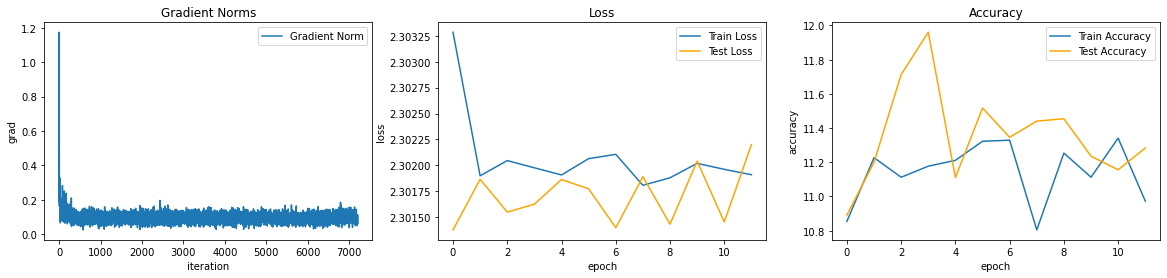

In [24]:
figure, ax= plt.subplots(1,3,figsize=(20,4))

ax[0].plot(model_grad_norms[0],label="Gradient Norm")
ax[0].set_title("Gradient Norms")
ax[0].set_xlabel("iteration")
ax[0].set_ylabel("grad")
ax[0].legend()

ax[1].plot(model_loss[0],label="Train Loss")
ax[1].plot(model_test_loss[0],color='orange',label="Test Loss")
ax[1].set_title("Loss")
ax[1].set_xlabel("epoch")
ax[1].set_ylabel("loss")
ax[1].legend()

ax[2].plot(model_accuracy[0],label="Train Accuracy")
ax[2].plot(model_test_accuracy[0],label="Test Accuracy",color='orange')
ax[2].set_title("Accuracy")
ax[2].set_xlabel("epoch")
ax[2].set_ylabel("accuracy")
ax[2].legend()

plt.show()

## HW1 : 3.2 Number of parameters v.s. Generalization

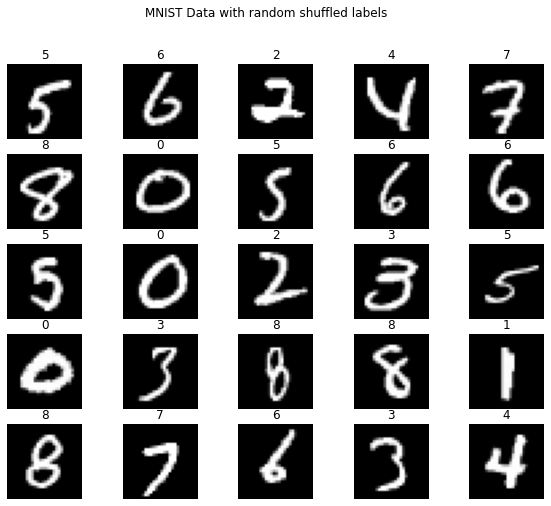

{'train': <torch.utils.data.dataloader.DataLoader at 0x1520e55872e0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x1520e55a4730>}

In [25]:
train_data_correct = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download = True,
)

test_data_correct = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download = False,
)

figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
plt.suptitle("MNIST Data with random shuffled labels")
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data_correct), size=(1,)).item()
    img, label = train_data_correct[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

cloaders = {'train': Data.DataLoader(train_data_correct,
                                               batch_size=100,
                                               shuffle=True,
                                               num_workers=1),
          'test': Data.DataLoader(test_data_correct,
                                             batch_size=100,
                                             shuffle=True,
                                             num_workers=1)
          }

cloaders

In [26]:
class DNN0(nn.Module):
    def __init__(self):
        super(DNN0, self).__init__()
        self.linear1 = nn.Linear(784,0)
        self.linear2 = nn.Linear(0,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1), X

class DNN1(nn.Module):
    def __init__(self):
        super(DNN1, self).__init__()
        self.linear1 = nn.Linear(784,1)
        self.linear2 = nn.Linear(1,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1), X

class DNN2(nn.Module):
    def __init__(self):
        super(DNN2, self).__init__()
        self.linear1 = nn.Linear(784,2)
        self.linear2 = nn.Linear(2,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1), X
    
    
class DNN10(nn.Module):
    def __init__(self):
        super(DNN10, self).__init__()
        self.linear1 = nn.Linear(784,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = self.linear1(X)
        return F.log_softmax(X, dim=1), X

class DNN50(nn.Module):
    def __init__(self):
        super(DNN50, self).__init__()
        self.linear1 = nn.Linear(784,50)
        self.linear2 = nn.Linear(50,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1), X
    
class DNN100(nn.Module):
    def __init__(self):
        super(DNN100, self).__init__()
        self.linear1 = nn.Linear(784,100)
        self.linear2 = nn.Linear(100,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = self.linear2(X)
        return F.log_softmax(X, dim=1), X
    
class DNN250(nn.Module):
    def __init__(self):
        super(DNN250, self).__init__()
        self.linear1 = nn.Linear(784,250)
        self.linear2 = nn.Linear(250,100)
        self.linear3 = nn.Linear(100,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = self.linear3(X)
        return F.log_softmax(X, dim=1), X
    
class DNN400(nn.Module):
    def __init__(self):
        super(DNN400, self).__init__()
        self.linear1 = nn.Linear(784,400)
        self.linear2 = nn.Linear(400,250)
        self.linear3 = nn.Linear(250,100)
        self.linear4 = nn.Linear(100,10)
    
    def forward(self,X):
        X = X.view(-1,784)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))
        X = F.relu(self.linear3(X))
        X = self.linear4(X)
        return F.log_softmax(X, dim=1), X

In [27]:
# models = [DNN0().to(device),DNN1().to(device),DNN2().to(device),
#           DNN3().to(device),DNN4().to(device),DNN5().to(device),
#           DNN6().to(device),DNN7().to(device),DNN8().to(device),
#           DNN9().to(device),DNN10().to(device),DNN50().to(device),
#           DNN100().to(device),DNN150().to(device),DNN250().to(device)]

# models = [DNN2().to(device),DNN5().to(device),DNN10().to(device),DNN50().to(device),DNN100().to(device),DNN250().to(device)]

models = [DNN400().to(device),DNN250().to(device),DNN100().to(device),DNN50().to(device),DNN10().to(device),DNN2().to(device),DNN1().to(device)] #DNN5().to(device),,

loss_functions = []
optimizers = []
parameters = []

num_epochs = 6
    
for model in models:
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    parameters.append(pytorch_total_params)

    model.train()

    optimizers.append(optim.Adam(model.parameters(), lr = 0.01))
    loss_functions.append(nn.CrossEntropyLoss())

model_train_loss=[]
model_train_acc=[]

for model, optimizer, loss_func in zip(models,optimizers,loss_functions):
    print(model)
    # Train the model
    total_step = len(cloaders['train'])

    train_loss =[]
    train_acc = []
    for epoch in range(num_epochs):
        correct=0
        b_loss=[]
        b_acc=[]
        
        for i, (images, labels) in enumerate(cloaders['train']):

            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device) # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)

            # clear gradients for this training step   
            optimizer.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step() 

            predicted = torch.max(output.data, 1)[1]
            correct += (predicted==b_y).sum()

            b_loss.append(loss.detach().cpu().item())
            b_acc.append(float(correct)*100/float(100*(i+1)))

            if (i+1)%200==0 and (epoch+1)%3==0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.3f}%'.format(epoch + 1, num_epochs, i + 1, total_step, b_loss[-1],b_acc[-1]))

        train_loss.append(np.average(b_loss))
        train_acc.append(np.average(b_acc))


    model_train_loss.append(train_loss)
    model_train_acc.append(train_acc)
    print("*"*100)

DNN400(
  (linear1): Linear(in_features=784, out_features=400, bias=True)
  (linear2): Linear(in_features=400, out_features=250, bias=True)
  (linear3): Linear(in_features=250, out_features=100, bias=True)
  (linear4): Linear(in_features=100, out_features=10, bias=True)
)
Epoch [3/6], Step [200/600], Loss: 0.0828, Accuracy: 96.790%
Epoch [3/6], Step [400/600], Loss: 0.1193, Accuracy: 96.657%
Epoch [3/6], Step [600/600], Loss: 0.1750, Accuracy: 96.600%
Epoch [6/6], Step [200/600], Loss: 0.1573, Accuracy: 97.880%
Epoch [6/6], Step [400/600], Loss: 0.0967, Accuracy: 97.570%
Epoch [6/6], Step [600/600], Loss: 0.0840, Accuracy: 97.527%
****************************************************************************************************
DNN250(
  (linear1): Linear(in_features=784, out_features=250, bias=True)
  (linear2): Linear(in_features=250, out_features=100, bias=True)
  (linear3): Linear(in_features=100, out_features=10, bias=True)
)
Epoch [3/6], Step [200/600], Loss: 0.0693, Accuracy: 

In [28]:
def test(model,lfunc):
    # Test the model
    model.eval()
    with torch.no_grad():
        for images, labels in cloaders['train']:
            images = Variable(images).to(device) # batch x
            labels = Variable(labels).to(device)   # batch y
            train_output, last_layer = model(images)
            train_loss = lfunc(train_output, labels)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            train_accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        for images, labels in cloaders['test']:
            images = Variable(images).to(device) # batch x
            labels = Variable(labels).to(device)   # batch y
            test_output, last_layer = model(images)
            test_loss = lfunc(test_output, labels)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    return (train_accuracy,train_loss.detach().cpu().item(),test_accuracy,test_loss.detach().cpu().item())

param_arr=[]
train_acc_arr =[]
train_loss_arr=[]
test_acc_arr=[]
test_loss_arr=[]

for (model,lossfunc) in zip(models,loss_functions):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    train_acc, train_loss, test_acc, test_loss = test(model,lossfunc)
    
    param_arr.append(pytorch_total_params)
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    
    test_loss_arr.append(test_loss)
    test_acc_arr.append(test_acc)
    
    print("Parameters: {}\tTrain Accuracy: {}\tTrain Loss: {}\tTest Accuracy: {}\tTest Loss: {}".format(pytorch_total_params,train_acc, train_loss, test_acc, test_loss))

Parameters: 440360	Train Accuracy: 0.98	Train Loss: 0.04050023853778839	Test Accuracy: 0.96	Test Loss: 0.1872311532497406
Parameters: 222360	Train Accuracy: 1.0	Train Loss: 0.00569743849337101	Test Accuracy: 0.93	Test Loss: 0.44182583689689636
Parameters: 79510	Train Accuracy: 0.99	Train Loss: 0.028578970581293106	Test Accuracy: 0.97	Test Loss: 0.09688463062047958
Parameters: 39760	Train Accuracy: 0.97	Train Loss: 0.10867805778980255	Test Accuracy: 0.93	Test Loss: 0.22919465601444244
Parameters: 7850	Train Accuracy: 0.94	Train Loss: 0.21618400514125824	Test Accuracy: 0.93	Test Loss: 0.21958690881729126
Parameters: 1600	Train Accuracy: 0.66	Train Loss: 1.0101957321166992	Test Accuracy: 0.6	Test Loss: 1.209274411201477
Parameters: 805	Train Accuracy: 0.32	Train Loss: 1.7232497930526733	Test Accuracy: 0.29	Test Loss: 1.8386842012405396


In [29]:
# torch.cuda.empty_cache()

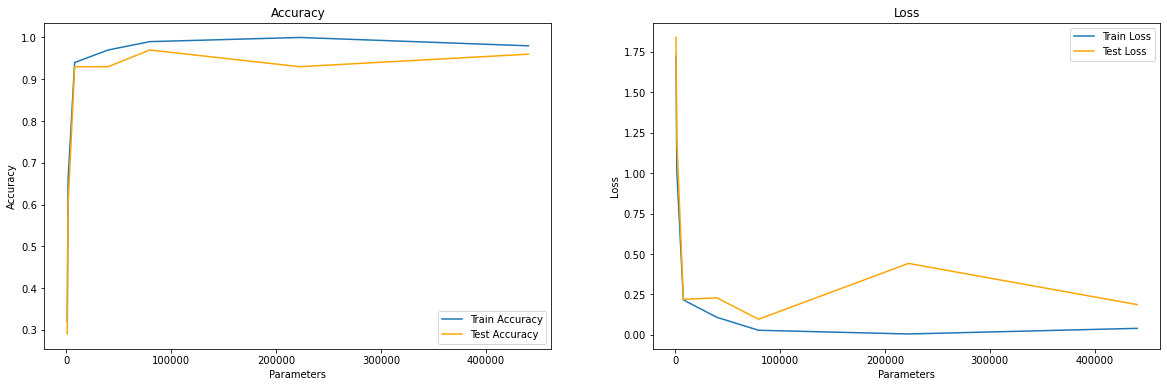

In [30]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

ax[0].plot(param_arr,train_acc_arr,label="Train Accuracy")
ax[0].plot(param_arr,test_acc_arr,label="Test Accuracy",color='orange')
ax[0].set_xlabel("Parameters")
ax[0].set_ylabel("Accuracy")
ax[0].set_title("Accuracy")
ax[0].legend()

ax[1].plot(param_arr,train_loss_arr,label="Train Loss")
ax[1].plot(param_arr,test_loss_arr,label="Test Loss",color='orange')
ax[1].set_xlabel("Parameters")
ax[1].set_ylabel("Loss")
ax[1].set_title("Loss")
ax[1].legend()

plt.show()

## HW1 : 3.3 Flatness vs. Generalization Part 1

In [31]:
train_data = datasets.MNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    download = True,
)

test_data = datasets.MNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    download = False,
)

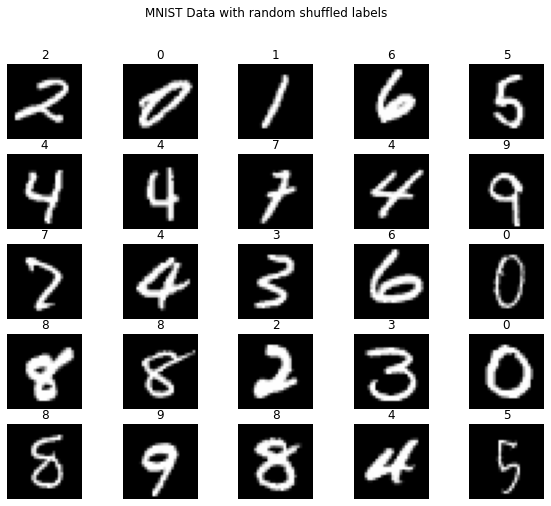

In [32]:
figure = plt.figure(figsize=(10,8))
cols, rows = 5,5
plt.suptitle("MNIST Data with random shuffled labels")
for i in range(1, cols*rows+1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows,cols,i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap='gray')
plt.show()

In [33]:
# class DNN1(nn.Module):
#     def __init__(self):
#         super(DNN1, self).__init__()
#         self.linear1 = nn.Linear(784,250)
#         self.linear2 = nn.Linear(250,100)
#         self.linear3 = nn.Linear(100,10)
    
#     def forward(self,X):
#         X = X.view(-1,784)
#         X = F.relu(self.linear1(X))
#         X = F.relu(self.linear2(X))
#         X = self.linear3(X)
#         return F.log_softmax(X, dim=1), X
    
# class CNN3(nn.Module):
#     def __init__(self):
#         super(CNN3, self).__init__()
#         self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
#         self.conv2 = nn.Conv2d(32, 32, kernel_size=5)
#         self.conv3 = nn.Conv2d(32,64, kernel_size=5)
#         self.fc1 = nn.Linear(3*3*64, 256)
#         self.fc2 = nn.Linear(256, 10)

#     def forward(self, x):
#         x = F.relu(self.conv1(x))
#         #x = F.dropout(x, p=0.5, training=self.training)
#         x = F.relu(F.max_pool2d(self.conv2(x), 2))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = F.relu(F.max_pool2d(self.conv3(x),2))
#         x = F.dropout(x, p=0.5, training=self.training)
#         x = x.view(-1,3*3*64 )
#         x = F.relu(self.fc1(x))
#         x = F.dropout(x, training=self.training)
#         x = self.fc2(x)
#         return F.log_softmax(x, dim=1), x
    
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = torch.nn.Conv2d(1, 32, (3,3))
        self.conv2 = torch.nn.Conv2d(32, 64, (3,3))

        self.drop1 = torch.nn.Dropout2d(0.25)
        self.drop2 = torch.nn.Dropout2d(0.5)

        self.fc1 = torch.nn.Linear(9216, 128)
        self.fc2 = torch.nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.drop1(F.max_pool2d(x, 2))

        x = x.flatten(1)
        x = F.relu(self.fc1(x))
        x = self.drop2(x)
        x = self.fc2(x)

        return F.log_softmax(x, 1), x

In [34]:
loaders64 = {'train': Data.DataLoader(train_data,
                                               batch_size=64,
                                               shuffle=True,
                                               num_workers=1),
          'test': Data.DataLoader(test_data,
                                             batch_size=64,
                                             shuffle=True,
                                             num_workers=1)
          }

loaders1024 = {'train': Data.DataLoader(train_data,
                                               batch_size=1024,
                                               shuffle=True,
                                               num_workers=10),
          'test': Data.DataLoader(test_data,
                                             batch_size=1024,
                                             shuffle=True,
                                             num_workers=10)
          }


/home/gpisal/.local/lib/python3.9/site-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 10 worker processes in total. Our suggested max number of worker in current system is 8, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [35]:
cnn_models = [Net().to(device),Net().to(device)]
loss_functions = []
optimizers = [optim.Adam(model.parameters(), lr = 0.001),optim.Adam(model.parameters(), lr = 0.01)]
num_epochs = 12
loaders = [loaders64,loaders1024]

for model in cnn_models:
    print(model)
    model.train()
    loss_functions.append(nn.CrossEntropyLoss())
    
for model, optimizer, loss_func, loader in zip(cnn_models,optimizers,loss_functions,loaders):
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loader['train']):
            model.train()
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images).to(device) # batch x
            b_y = Variable(labels).to(device)   # batch y
            output = model(b_x)[0]               
            loss = loss_func(output, b_y)

            # clear gradients for this training step   
            optimizer.zero_grad()           

            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout2d(p=0.25, inplace=False)
  (drop2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)
Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (drop1): Dropout2d(p=0.25, inplace=False)
  (drop2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


/home/gpisal/.local/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


In [36]:
def test(model,lfunc,loader):
    # Test the model
    model.eval()
    with torch.no_grad():
        for images, labels in loader['train']:
            images = Variable(images).to(device) # batch x
            labels = Variable(labels).to(device)   # batch y
            train_output, last_layer = model(images)
            train_loss = lfunc(train_output, labels)
            pred_y = torch.max(train_output, 1)[1].data.squeeze()
            train_accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
        for images, labels in loader['test']:
            images = Variable(images).to(device) # batch x
            labels = Variable(labels).to(device)   # batch y
            test_output, last_layer = model(images)
            test_loss = lfunc(test_output, labels)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            test_accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
    return (train_accuracy,train_loss.detach().cpu().item(),test_accuracy,test_loss.detach().cpu().item())

param_arr=[]
train_acc_arr =[]
train_loss_arr=[]
test_acc_arr=[]
test_loss_arr=[]

for (model,lossfunc,loader) in zip(cnn_models,loss_functions,loaders):
    pytorch_total_params = sum(p.numel() for p in model.parameters())
    train_acc, train_loss, test_acc, test_loss = test(model,lossfunc,loader)
    
    param_arr.append(pytorch_total_params)
    train_acc_arr.append(train_acc)
    train_loss_arr.append(train_loss)
    
    test_loss_arr.append(test_loss)
    test_acc_arr.append(test_acc)
    
    print("Parameters: {}\tTrain Accuracy: {}\tTrain Loss: {}\tTest Accuracy: {}\tTest Loss: {}".format(pytorch_total_params,train_acc, train_loss, test_acc, test_loss))

Parameters: 1199882	Train Accuracy: 0.0625	Train Loss: 2.3166661262512207	Test Accuracy: 0.0625	Test Loss: 2.289637565612793
Parameters: 1199882	Train Accuracy: 0.07401315789473684	Train Loss: 2.3033177852630615	Test Accuracy: 0.0778061224489796	Test Loss: 2.303879499435425


In [37]:
from torch.nn.utils import (
    parameters_to_vector as Params2Vec,
    vector_to_parameters as Vec2Params
)

def theta_alpha(alpha, theta, theta_ast):
    return alpha * theta_ast + (1 - alpha) * theta



In [41]:
results = []
for model,loader in zip(cnn_models,loaders):
    learnt_model = model

    learnt_net = Net().to(device)
    learnt_net.load_state_dict(learnt_model.state_dict())
    theta_ast = Params2Vec(learnt_net.parameters())

    inference_net = Net().to(device)
    theta = Params2Vec(inference_net.parameters())

    loss_fn = torch.nn.NLLLoss()
    # loss_fn = nn.CrossEntropyLoss()

    print('Initialized Model!')
    train_losses = {}
    test_losses = {}
    train_accuracy ={}
    test_accuracy={}

    for alpha in torch.arange(-20,20,1):
        local_loss=[]
        local_accuracy=[]
        for images, labels in loader['train']:
            with torch.no_grad():
                Vec2Params(theta_alpha(alpha, theta, theta_ast), inference_net.parameters())
                inference_net.eval()

                images = Variable(images).to(device) # batch x
                labels = Variable(labels).to(device)   # batch y

                prediction = inference_net(images)[0]

                loss = loss_fn(prediction, labels)

                local_loss.append(loss.detach().cpu().item())

                pred_y = torch.max(prediction, 1)[1].data.squeeze()
                local_accuracy.append((pred_y == labels).sum().item() / float(labels.size(0)))

        train_losses[alpha]=np.average(local_loss)
        train_accuracy[alpha]=np.average(local_accuracy)

        local_loss=[]
        local_accuracy=[]
        for images, labels in loader['test']:
            with torch.no_grad():
                Vec2Params(theta_alpha(alpha, theta, theta_ast), inference_net.parameters())
                inference_net.eval()

                images = Variable(images).to(device) # batch x
                labels = Variable(labels).to(device)   # batch y

                prediction = inference_net(images)[0]

                loss = loss_fn(prediction, labels)

                local_loss.append(loss.detach().cpu().item())

                pred_y = torch.max(prediction, 1)[1].data.squeeze()
                local_accuracy.append((pred_y == labels).sum().item() / float(labels.size(0)))

        test_losses[alpha]=np.average(local_loss)
        test_accuracy[alpha]=np.average(local_accuracy)
        
    print("Model Results Done!")
    results.append([train_losses,train_accuracy,test_losses,test_accuracy])

Initialized Model!
Model Results Done!
Initialized Model!
Model Results Done!


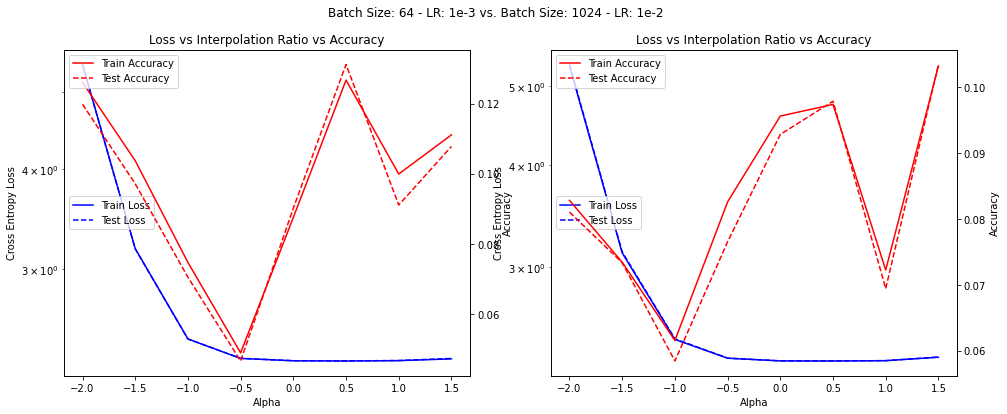

In [43]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

for idx,result in enumerate(results):
    train_losses = result[0]
    train_accuracy = result[1]
    test_losses = result[2]
    test_accuracy = result[3]
    
    ax[idx].semilogy(train_losses.keys(),train_losses.values(),'b-',label="Train Loss")
    ax[idx].semilogy(test_losses.keys(),test_losses.values(),'b--',label="Test Loss")

    ax[idx].set_ylabel('Cross Entropy Loss')
    ax[idx].set_xlabel('Alpha')
    # ax.set_yscale('log')

    ax2 = ax[idx].twinx()
    ax2.plot(train_accuracy.keys(),train_accuracy.values(),'r-',label="Train Accuracy")
    ax2.plot(test_accuracy.keys(),test_accuracy.values(),'r--',label="Test Accuracy")
    ax2.set_ylabel('Accuracy')


    ax[idx].set_title('Loss vs Interpolation Ratio vs Accuracy')
    ax[idx].legend(loc='center left')
    ax2.legend(loc='upper left')
    
plt.suptitle("Batch Size: 64 - LR: 1e-3 vs. Batch Size: 1024 - LR: 1e-2")
plt.show()

Ref: https://medium.com/mlearning-ai/visualising-the-loss-landscape-3a7bfa1c6fdf

## HW1 3.3 Flatness vs. Generalization part 2

In [44]:
def confusion(prediction, truth):
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_vector = prediction / truth
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_vector == 1).item()
    false_positives = torch.sum(confusion_vector == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_vector)).item()
    false_negatives = torch.sum(confusion_vector == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives

Ref: https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d

In [45]:
batchsize_workermap = {8:1, 16:1, 32:1, 64:2, 128:3, 256:4, 512:6, 1024:8, 2048:10}
# batchsize_workermap = {64:2}
learning_rates=[0.01,0.001]
results = {0.01:[],0.001:[]}

for bs, wc in batchsize_workermap.items():
    for lr in learning_rates:
        loaders = {'train': Data.DataLoader(train_data,
                                               batch_size=bs,
                                               shuffle=True,
                                               num_workers=wc),
          'test': Data.DataLoader(test_data,
                                             batch_size=bs,
                                             shuffle=True,
                                             num_workers=wc)
          }
        
        
        cnn_models = [Net().to(device)]
        loss_functions = [nn.CrossEntropyLoss()]
        for model in cnn_models:
            optimizers = [optim.Adam(model.parameters(), lr = lr)]
        num_epochs = 12
        loaders = [loaders]


        for model, optimizer, loss_func, loader in zip(cnn_models,optimizers,loss_functions,loaders):
#             print(model)
            model.train()
            gradloss_wrt_ip = []
            for epoch in range(num_epochs):
                local_gradloss_wrt_ip = []
                for i, (images, labels) in enumerate(loader['train']):
                    model.train()
                    # gives batch data, normalize x when iterate train_loader
#                     b_x = Variable(images, requires_grad=True).to(device) # batch x
                    b_x = Variable(images).to(device) # batch x
                    b_y = Variable(labels).to(device)   # batch y
                    output = model(b_x)[0]               
                    loss = loss_func(output, b_y)
                    
                    with torch.no_grad():
                        grads_p = torch.autograd.grad(loss, model.parameters(), create_graph=True)[0]
                        local_gradloss_wrt_ip.append(grads_p.norm(2).detach().cpu().item())
                    
                    # clear gradients for this training step   
                    optimizer.zero_grad()           

                    # backpropagation, compute gradients 
                    loss.backward()    
                    # apply gradients             
                    optimizer.step()
                gradloss_wrt_ip.append(np.average(local_gradloss_wrt_ip))
            sensitivity = np.average(gradloss_wrt_ip)
            
            train_loss_arr = [] 
            test_loss_arr =[]
            train_acc_arr=[]
            test_acc_arr=[]
            
            model.eval()
            with torch.no_grad():
                local_loss=[]
                local_acc=[]
                for images, labels in loader['train']:
                    images = Variable(images).to(device) # batch x
                    labels = Variable(labels).to(device)   # batch y
                    train_output, last_layer = model(images)
                    train_loss = loss_func(train_output, labels)
                    pred_y = torch.max(train_output, 1)[1].data.squeeze()
                    local_loss.append(train_loss.detach().cpu().item())
                    local_acc.append((pred_y == labels).sum().item() / float(labels.size(0)))

                    pass
                train_loss_arr.append(np.average(local_loss))
                train_acc_arr.append(np.average(local_acc))

                
                local_loss=[]
                local_acc=[]
                for images, labels in loader['test']:
                    images = Variable(images).to(device) # batch x
                    labels = Variable(labels).to(device)   # batch y
                    test_output, last_layer = model(images)
                    test_loss = loss_func(test_output, labels)
                    pred_y = torch.max(test_output, 1)[1].data.squeeze()
                    local_loss.append(test_loss.detach().cpu().item())
                    local_acc.append((pred_y == labels).sum().item() / float(labels.size(0)))

                    pass
                test_loss_arr.append(np.average(local_loss))
                test_acc_arr.append(np.average(local_acc))
                
            results[lr].append([sensitivity, np.average(train_loss_arr), np.average(test_loss_arr), np.average(train_acc_arr), np.average(test_acc_arr)])

        print("BS: ",bs," Workers:",wc," LR:",lr," Results: ",results[lr][-1]," DONE!!!")

BS:  8  Workers: 1  LR: 0.01  Results:  [1.2348992859631533, 0.25183381396484716, 0.2618381225990131, 0.9296666666666666, 0.926]  DONE!!!
BS:  8  Workers: 1  LR: 0.001  Results:  [0.6393418177184504, 0.00801627588446243, 0.03868146310043679, 0.9975666666666667, 0.9897]  DONE!!!
BS:  16  Workers: 1  LR: 0.01  Results:  [0.00012042234350487383, 2.302295006942749, 2.3019311595916747, 0.11236666666666667, 0.1135]  DONE!!!
BS:  16  Workers: 1  LR: 0.001  Results:  [0.4039232240779136, 0.0061421497858843, 0.04007181390483801, 0.9979333333333333, 0.9903]  DONE!!!
BS:  32  Workers: 1  LR: 0.01  Results:  [0.992160201564959, 0.07256220849429568, 0.09423601720884264, 0.9781833333333333, 0.974241214057508]  DONE!!!
BS:  32  Workers: 1  LR: 0.001  Results:  [0.28859913755127375, 0.004261813248116232, 0.030680513544967352, 0.9987666666666667, 0.9922124600638977]  DONE!!!
BS:  64  Workers: 2  LR: 0.01  Results:  [0.7042456865315528, 0.06826110893283595, 0.08737175955265096, 0.9797774520255863, 0.975

In [102]:
print(results)

{0.01: [[1.5250019434554434, 0.3245940424535113, 0.32452386535853145, 0.9139, 0.912], [1.6166755772517731, 0.10389822202607368, 0.1192884744216688, 0.9716, 0.9649], [0.7892013415413598, 0.09604618487063174, 0.11397667686263778, 0.971, 0.9656549520766773], [0.729200778570418, 0.04686537358427305, 0.06814058665423446, 0.9860740938166311, 0.9806926751592356], [0.44886721127687057, 0.05174116326916987, 0.06849508045264814, 0.984325026652452, 0.978935917721519], [0.2874450251377511, 0.035412474267898085, 0.05440846807323396, 0.9896110372340425, 0.98330078125], [0.16628859778813554, 0.023667497520919067, 0.04377762675285339, 0.9925957803672316, 0.9870461856617647], [0.12078768142043893, 0.01340810673595485, 0.03545076120644808, 0.9959334578501339, 0.9885224011479592], [0.10583194873761387, 0.060367401440938315, 0.07612655013799667, 0.9827157003837719, 0.9764544731747786]], 0.001: [[0.5925222989717464, 0.008181734829256286, 0.03759699638194829, 0.9974333333333333, 0.9894], [0.4117113255822715

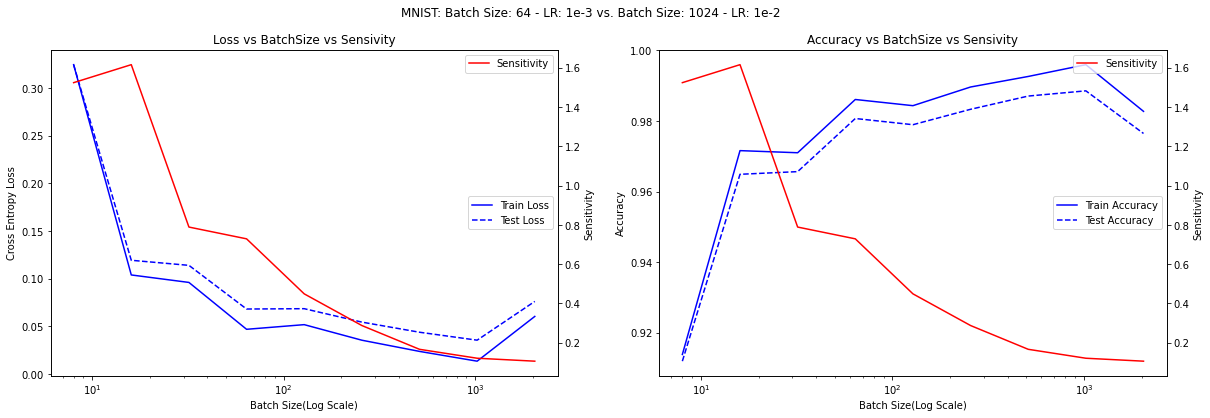

In [103]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

bs=[8, 16, 32, 64, 128, 256, 512, 1024, 2048]
sensitivity = [x[0] for x in results[0.01]]
train_losses = [x[1] for x in results[0.01]]
test_losses = [x[2] for x in results[0.01]]
train_accuracy = [x[3] for x in results[0.01]]
test_accuracy = [x[4] for x in results[0.01]]

ax[0].plot(bs,train_losses,'b-',label="Train Loss")
ax[0].plot(bs,test_losses,'b--',label="Test Loss")

ax[0].set_ylabel('Cross Entropy Loss')
ax[0].set_xlabel('Batch Size(Log Scale)')
ax[0].set_xscale('log')

ax2 = ax[0].twinx()
ax2.plot(bs,sensitivity,'r-',label="Sensitivity")
ax2.set_ylabel('Sensitivity')
ax2.set_xscale('log')

ax[0].set_title('Loss vs BatchSize vs Sensivity')
ax[0].legend(loc='center right')
ax2.legend(loc='upper right')
    
ax[1].plot(bs,train_accuracy,'b-',label="Train Accuracy")
ax[1].plot(bs,test_accuracy,'b--',label="Test Accuracy")

ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Batch Size(Log Scale)')
ax[1].set_xscale('log')

ax2 = ax[1].twinx()
ax2.plot(bs,sensitivity,'r-',label="Sensitivity")
ax2.set_ylabel('Sensitivity')
ax2.set_xscale('log')


ax[1].set_title('Accuracy vs BatchSize vs Sensivity')
ax[1].legend(loc='center right')
ax2.legend(loc='upper right')
    
plt.suptitle("MNIST: Batch Size: 64 - LR: 1e-3 vs. Batch Size: 1024 - LR: 1e-2")
plt.show()

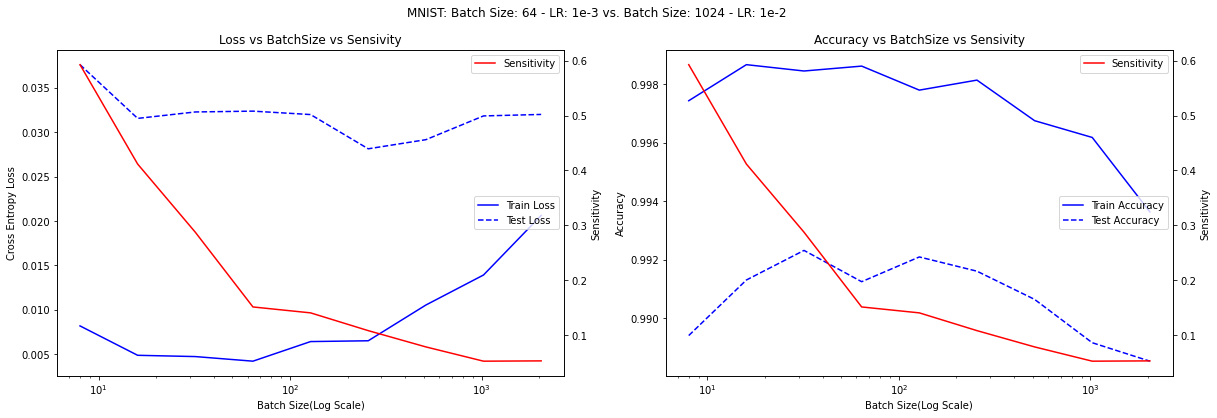

In [104]:
fig, ax = plt.subplots(1,2,figsize=(20,6))

bs=[8, 16, 32, 64, 128, 256, 512, 1024, 2048]
sensitivity = [x[0] for x in results[0.001]]
train_losses = [x[1] for x in results[0.001]]
test_losses = [x[2] for x in results[0.001]]
train_accuracy = [x[3] for x in results[0.001]]
test_accuracy = [x[4] for x in results[0.001]]

ax[0].plot(bs,train_losses,'b-',label="Train Loss")
ax[0].plot(bs,test_losses,'b--',label="Test Loss")

ax[0].set_ylabel('Cross Entropy Loss')
ax[0].set_xlabel('Batch Size(Log Scale)')
ax[0].set_xscale('log')

ax2 = ax[0].twinx()
ax2.plot(bs,sensitivity,'r-',label="Sensitivity")
ax2.set_ylabel('Sensitivity')
ax2.set_xscale('log')

ax[0].set_title('Loss vs BatchSize vs Sensivity')
ax[0].legend(loc='center right')
ax2.legend(loc='upper right')
    
ax[1].plot(bs,train_accuracy,'b-',label="Train Accuracy")
ax[1].plot(bs,test_accuracy,'b--',label="Test Accuracy")

ax[1].set_ylabel('Accuracy')
ax[1].set_xlabel('Batch Size(Log Scale)')
ax[1].set_xscale('log')

ax2 = ax[1].twinx()
ax2.plot(bs,sensitivity,'r-',label="Sensitivity")
ax2.set_ylabel('Sensitivity')
ax2.set_xscale('log')


ax[1].set_title('Accuracy vs BatchSize vs Sensivity')
ax[1].legend(loc='center right')
ax2.legend(loc='upper right')
    
plt.suptitle("MNIST: Batch Size: 64 - LR: 1e-3 vs. Batch Size: 1024 - LR: 1e-2")
plt.show()